In [1]:
import numpy as np
from numpy import *
from scipy.stats import norm
import pandas as pd
import pandas_datareader as pdr
import datetime
import ipywidgets as widgets
from ipywidgets import *
from ipywidgets import Output
from datetime import *
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style, scale

## Start w/ Simple Payoff Diagrams. Define `Strike`, `Spot`.

In [2]:
def get_payouts(df, step=5):                            #Loop through df of positions created by widgets, saved in portfolios.csv
    max_strike = df.Strike.max()
    min_strike = df.Strike.min()
    at_expire = [i for i in range(min_strike - 15, max_strike + 20, step)]

    for i in range(0,df.shape[0]):
        Position = df.Position.iloc[i].max()            #Define necessary variables to create payout diagram
        Type = df.Type.iloc[i]
        Quant = df.Quantity.iloc[i].max()
        Strike = df.Strike.iloc[i].max()
        Spot = df.Spot.iloc[i].max()                   #To be deleted
        Price = df.BS_Price.iloc[i].max() * Quant
        
        if Type == 'Call':
            Call=True
        else:
            Call=False
    
    
        if Call == True:
            payouts = [((100 * Quant) - Price) if at_expire[i] > Strike else (-Price) for i in range(0,len(at_expire))]
        else:
            payouts = [((100 * Quant) - Price) if at_expire[i] <= Strike else (-Price) for i in range(0,len(at_expire))]

        if i == 0:
            
            master = {
                'Asset Level' : at_expire,
                f"Payout_{Position}" : payouts
            }
        
        else:
            
            master[f"Payout_{Position}"] = payouts

    master = pd.DataFrame(master)    
    master.set_index('Asset Level', inplace=True)
    
    master['Net_Payouts'] = master.sum(axis=1,skipna=True)
    
    ######################################################################## Plot Net Payouts Diagram
    fig = plt.figure(figsize=(18,8))
    ax = plt.subplot(111)
    
    plt.plot(master.index, master.Net_Payouts, c='b')
    plt.axvline(x=Spot, c='g')
    plt.axhline(y=0,c='grey')
    
    return master

## Define Funtion to Find `Price` of Binary Option

In [3]:
def time_diff(end, start=datetime.now()):
    diff = end - start
    diff_in_s = diff.total_seconds()

    diff = int(diff_in_s)

    diff = diff / 31536000
    
    return diff

In [4]:
def binary_price(Spot, Strike, Maturity, Sigma, Call=True, rf=.0023, divs=0.02, Payout=100):
    
    d1 = (np.log(Spot/Strike) + (rf - divs + ((Sigma**2)/2) * Maturity)) / (Sigma * sqrt(Maturity))
    d2 = d1 - (Sigma * sqrt(Maturity))
    
    call = Payout * exp(-rf * Maturity) * norm.cdf(d2)
    put = Payout * exp(-rf * Maturity) * norm.cdf(-d2)
    
    if Call == True:
        return round(call,2)
    elif Call == False:
        return round(put,2)

## Perfrom Monte Carlo Simulation to Determine `Likely Payouts` and `Value At Risk`. Define `Vol`, `Drift`, `Time to Expire`

In [5]:
def mc_price(Spot, Drift, Sigma, Maturity):
    
    rand = round(random.random(),5)

    ret = round(norm.ppf(rand, 
                    loc= (Drift - (Sigma**2 / 2))*Maturity, 
                    scale= (Sigma * np.sqrt(Maturity))),
                5)

    price = Spot * exp(ret)
    
    return price

In [6]:
def monte_carlo(Strike, Drift, Sigma, Maturity, n=10000):
    level = []
    payout = []
    for i in range(0,n):
        price = mc_price(Spot, Drift, Sigma, Maturity)
        level.append(price)
        
        if price > Strike:
            payout.append(100)
        else:
            payout.append(0)
            
    df = {
        'Asset Level' : level,
        'Payout' : payout
    }
    df = pd.DataFrame(df)
    
    display(df.describe())
    
    fig = plt.figure(figsize=(18,8))
    plt.hist(df["Asset Level"], bins=50, density=False)
    plt.axvline(x=Strike, c='black')
    plt.show()
    
    return df

## Define Function to Combine Previous Functions 

In [7]:
def run_all(Spot, Strike, Sigma, Drift, Maturity, rf=.0023, divs=0.02, Payout=100, Call=True):
    get_payouts(Strike, Call=True, step=3)
    
    bp = binary_price(Spot, Strike, Maturity, Sigma, Call=True, rf=.0023, divs=0.02, Payout=100)
    
    if Call == True:
        type = 'Call'
    else:
        type = 'Put'
    
    print(f"{type} @ ${Strike} Black-Scholes Price: ${bp}")
    
    mc = monte_carlo(Strike, Drift, Sigma, Maturity)
    
    return mc

## Create necessary widget objects

In [8]:
Sigma = .75
Drift = .001
rf = 0.023

In [31]:
############################################# The following section is usually in a seperate cell so I can 
df = {                                       # refresh my portfolio every day, but still add to the DF throughout the day
    'Position' : [],
    'Datetime' : [],
    'Expire' : [],
    'Type' : [],
    'Quantity' : [],
    'Strike' : [],
    'Spot' : [],
    'BS_Price' : []
}

df = pd.DataFrame(df)
df.to_csv("portfolio.csv", index=False)
##############################################

In [32]:
Type = widgets.Dropdown(
    options = ['Call', 'Put'],
    value = 'Call',
    description= 'Select Binary Type',
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'max-content'}
)

Quantity = widgets.BoundedIntText(
    value=1,
    min=1,
    max=10,
    step=1,
    description='Quantity:',
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'max-content'}
)
                                  
Strike = widgets.BoundedIntText(
    min=1500,
    max=3500,
    step=1,
    description='Strike:',
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'max-content'}
)

Spot = widgets.BoundedIntText(
    min=1500,
    max=3500,
    step=1,
    description='Spot:',
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'max-content'}    
)


Add = widgets.Button(description="Add Data")
out = Output()

def add_on_click(b):
    
    dt = datetime.now()
    option = Type.value
    quant = Quantity.value
    strike = Strike.value
    spot = Spot.value
    
    df = pd.read_csv("portfolio.csv")
    now = datetime.now()
    
    if (dt.hour > 14) | ((dt.hour == 14) & (dt.minute > 15)):
        expire = datetime(now.year, now.month, now.day + 1, 14, 15,0,1)
    else:
        expire = datetime(now.year, now.month, now.day, 14, 15,0,1)
    
    Maturity = time_diff(end=expire, start=dt)
    
    if option == 'Call':
        t_f=True
    elif option == 'Put':
        t_f=False
    
    price = binary_price(spot, strike, Maturity, Sigma, Call=t_f, rf=.023, divs=0.02)
    
    
    add = {
        'Position' : df.shape[0] + 1,
        'Datetime' : dt,
        'Expire' : expire,
        'Type' : option,
        'Quantity': quant,
        'Strike' : strike,
        'Spot': spot,
        'BS_Price': price
    }
    
    add = pd.DataFrame(add, index=[0])

    df = pd.concat([df, add],sort=False) #ignore_index=True)
    df.set_index('Position', inplace=True)
    df.to_csv("portfolio.csv", index=True)
    
    #out.clear_output()
    display(df)
    #with out:
    #    display(df)

    
Add.on_click(add_on_click)
    
items = [Type, Quantity, Strike, Spot, Add]

box_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch',
                    width='100%')

box_auto = Box(children=items, layout=box_layout)

display_widgets = VBox([box_auto])
display_widgets

,Datetime,Expire,Type,Quantity,Strike,Spot,BS_Price
Position,,,,,,,
1,2020-03-19 01:46:15.622741,2020-03-19 14:15:00.000001,Put,1,2408,2380,62.6


,Datetime,Expire,Type,Quantity,Strike,Spot,BS_Price
Position,,,,,,,
1,2020-03-19 01:46:15.622741,2020-03-19 14:15:00.000001,Put,1,2408,2380,62.60
2,2020-03-19 01:46:26.754109,2020-03-19 14:15:00.000001,Call,1,2382,2381,53.07


,Position,Datetime,Expire,Type,Quantity,Strike,Spot,BS_Price
0,1,2020-03-19 01:46:15.622741,2020-03-19 14:15:00.000001,Put,1,2408,2380,62.60
1,2,2020-03-19 01:46:26.754109,2020-03-19 14:15:00.000001,Call,1,2382,2381,53.07


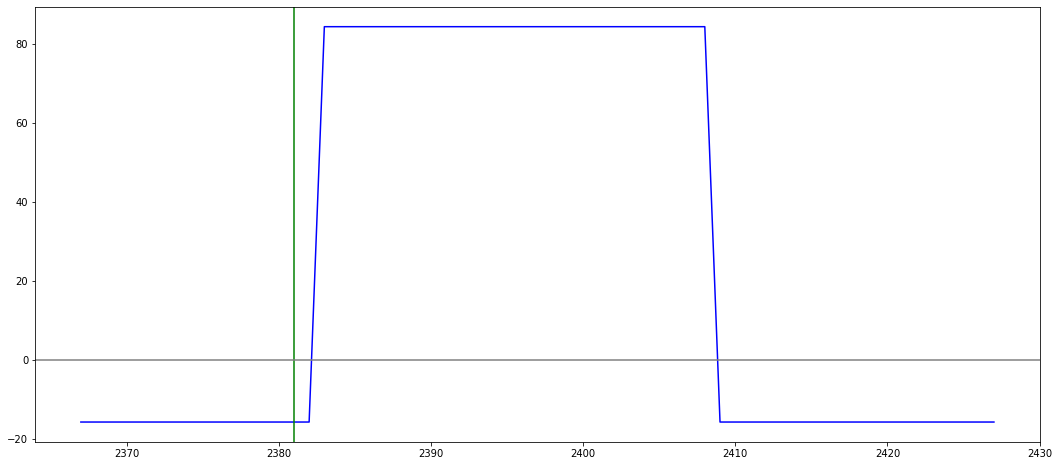

In [33]:
df = pd.read_csv('portfolio.csv')
display(df)

df = get_payouts(df, step=1)


In [ ]:
#Identify options to buy. Start w/ binary options only for now
Strike = 2558
Spot = 2501

now = datetime.now()
end = datetime(now.year, now.month, now.day+1, now.hour, now.minute, now.second)
Maturity = time_diff(end)

Sigma = .75
Drift = .02
rf = 0.0023

Buy = False
Sell = True
Quantity = 1
Value = -30

In [ ]:
mc = run_all(Spot, Strike, Sigma, Drift, Maturity, rf=.0023, divs=0.02, Payout=100, Call=True)

## Perform Historical Backtest to Determine Historical Payouts